In [1]:
!pip install numpy

In [2]:
!pip install opencv-python

In [3]:
import numpy as np
import argparse
import cv2
import os
import matplotlib.pyplot as plt

In [4]:
DIR="/content/drive/MyDrive/Deep learning pro/Copy of colorize.py"
prot_path="/content/drive/MyDrive/Deep learning pro/colorization_deploy_v2.prototxt"
point_path="/content/drive/MyDrive/Deep learning pro/pts_in_hull (6).npy"
caffe_model="/content/drive/MyDrive/Deep learning pro/KUMARANVASANTH.caffemodel"

In [5]:

dnn_net = cv2.dnn.readNetFromCaffe(prot_path,caffe_model)
kernel = np.load(point_path)
Id = dnn_net.getLayerId("class8_ab")
Id2 = dnn_net.getLayerId("conv8_313_rh")
kernel = kernel.transpose().reshape(2,313,1,1)
dnn_net.getLayer(Id).blobs = [kernel.astype("float32")]
dnn_net.getLayer(Id2).blobs = [np.full([1,313],2.606,dtype='float32')]

In [7]:
image = cv2.imread("/content/bb.png")
image = image.astype("float32")/255.0
lab = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)

In [8]:
resized = cv2.resize(lab,(522,715))
L = cv2.split(resized)[0]
L -= 50

In [9]:
dnn_net.setInput(cv2.dnn.blobFromImage(L))
ab = dnn_net.forward()[0, :, :, :].transpose((1,2,0))
ab = cv2.resize(ab, (image.shape[1],image.shape[0]))

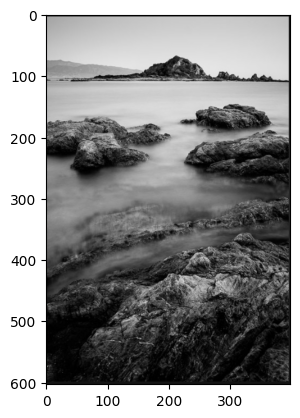

In [10]:
L= cv2.split(lab)[0]
colorized = np.concatenate((L[:,:,np.newaxis], ab), axis=2)
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2RGB)
colorized = np.clip(colorized, 0, 1)
colorized = (255 * colorized).astype("uint8")
plt.imshow(image)

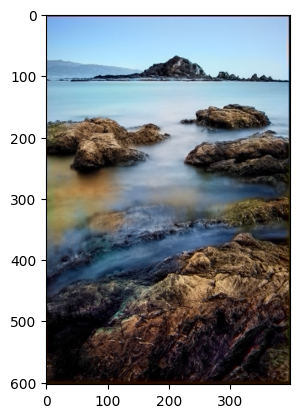

In [11]:
plt.imshow(colorized)


In [12]:
from skimage.metrics import structural_similarity as ssim
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err
mse_value = mse(image, colorized)
ssim_value, _ = ssim(image, colorized, full=True, multichannel=True)
print(f"MSE: {mse_value}")
print(f"SSIM: {ssim_value}")

MSE: 48671.70801114554
SSIM: 0.00010000402107834816


<ipython-input-12-dcdc770f389c>:7: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value, _ = ssim(image, colorized, full=True, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [15]:
def psnr(imageA, imageB, max_pixel=255.0):
    mse_value = mse(imageA, imageB)
    if mse_value == 0:
        return float('inf')
    return 20 * np.log10(max_pixel) - 10 * np.log10(mse_value)
psnr_value = psnr(image, colorized)
print(f"PSNR: {psnr_value} dB")

PSNR: 1.2580377388472925 dB
